**Projeto da disciplina de Data Mining**

**PESC - Programa de Engenharia de Sistemas e Computação**

**COPPE / UFRJ**

Autores: Bernardo Souza e Rafael Lopes Conde dos Reis

GitHub: https://github.com/condereis/credit-card-default/


# Resumo



# Pacotes Utilizados

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import auc, confusion_matrix, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

%matplotlib inline

In [2]:
train = pd.read_csv('../data/processed/train.csv', index_col=0)
del train.index.name

X = train.drop(['default.payment.next.month', axis=1)
y = train['default.payment.next.month']
train.head()


,LIMIT_BAL,SEX,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month,RELATIVE_DEBT,ED_1,ED_2,ED_3,ED_4
4937,-1.136720,0,0,-1.246020,-1,-1,-1,-1,-1,-2,...,-0.252500,-0.308063,-0.314136,-0.293382,0,0.941268,1,0,0,0
4789,-0.365981,0,1,1.791598,2,0,0,0,0,0,...,-0.126411,0.011102,-0.117776,-0.124626,0,-0.692300,0,1,0,0
8448,-0.751350,1,0,-1.029047,0,0,0,0,0,0,...,-0.068138,-0.259869,-0.246785,0.004922,1,0.017958,0,1,0,0
4536,0.481833,0,0,0.164303,1,-2,-2,-2,-2,-2,...,-0.296801,-0.308063,-0.314136,-0.293382,1,0.941268,0,1,0,0
27564,-0.288907,0,0,2.225543,0,0,0,0,0,0,...,0.157572,-0.052731,-0.052323,-0.012122,0,-1.362466,0,1,0,0


# Banchmarks

## Escolha da classe mais frequente

A acurácia de escolher a classe mais frequente é de 77,92%. Isso mostra que esse é um problema de classes desbalanceadas, de forma que a acurácia não é a melhor métrica para ser utilizada. Escolheu-se usar, então, como métrica a AUC (area under the curve), que representa a área sobre a curva ROC. A curva ROC, nada mais é do que uma curva, onde cada ponto corresponde a probabilidade de detecção e a probabilidade de falso alarme para um determinado valor de limiar de classificação.

Acurácia: 0.779238095238


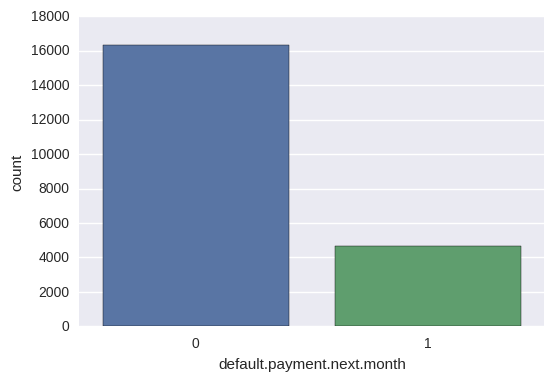

In [3]:
print 'Acurácia:', max(y.mean(), 1-y.mean())
sns.countplot(y)

## Naive Bayes

Foi utilizado como banchmarck para os demais modelos testados a eficiência em termos de AUC do Naive Bayes. Como pode-se observar, a eficiência A seguir é plotada a curva ROC e a matriz de confusão para o limiar de corte em 0.5.

In [4]:
model = GaussianNB()
scores = cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring='roc_auc')
print 'Naive Bayes (AUC): %f +- %f' % (np.mean(scores), np.std(scores))
scores = cross_val_score(model, X, y, cv=5, n_jobs=-1)
print 'Naive Bayes (acurácia): %f +- %f' % (np.mean(scores), np.std(scores))

Naive Bayes (AUC): 0.736788 +- 0.008634
Naive Bayes (acurácia): 0.604472 +- 0.030844


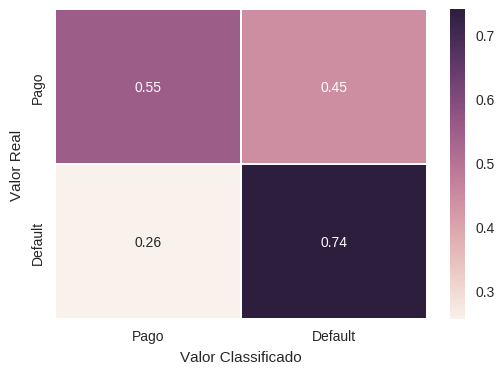

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
model = GaussianNB()
y_pred = model.fit(X_train,y_train).predict(X_test)
labels = ['Pago', 'Default']
mtx = confusion_matrix(y_test, y_pred)
mtx = [x/float(sum(x)) for x in mtx]
sns.heatmap(pd.DataFrame(mtx, columns=labels, index=labels), annot=True, fmt=".2f", linewidths=.5)
plt.xlabel('Valor Classificado')
plt.ylabel('Valor Real')

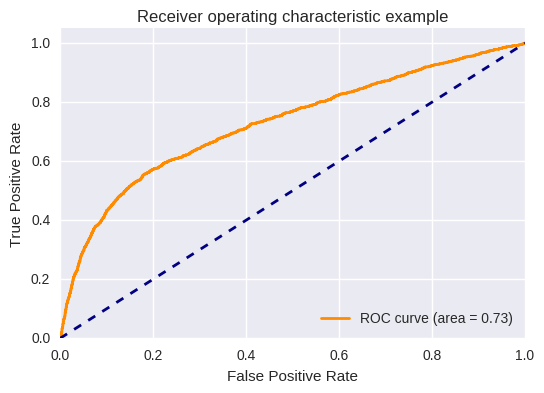

In [6]:
y_pred = model.fit(X_train, y_train).predict_proba(X_test)
y_pred = np.array([x[1] for x in y_pred])
fpr, tpr, thresholds = roc_curve(y_test+1, y_pred, pos_label=2)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Logistic Regression

## Redução de dimensionalidade

<Container object of 3 artists>

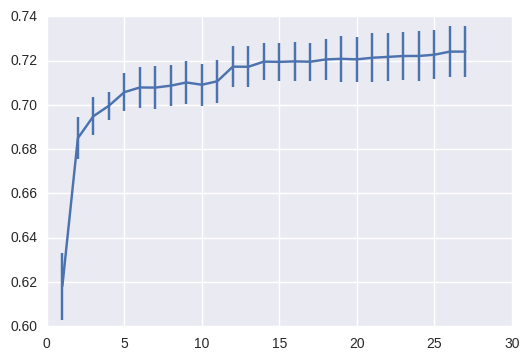

In [27]:
score_list = []
error_list = []
n_dims = range(1,train.shape[1])
model = LogisticRegression()
for dim in n_dims:
    reduced_data = PCA(n_components=dim).fit_transform(X)
    scores = cross_val_score(model, reduced_data, y,
                             cv=5, n_jobs=-1, scoring='roc_auc')
    score_list.append(np.mean(scores))
    error_list.append(np.std(scores))
plt.errorbar(n_dims, score_list, yerr=error_list)

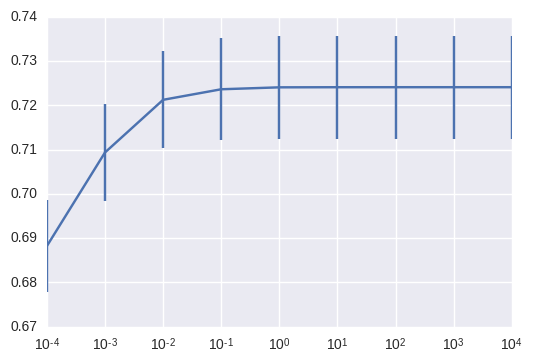

In [36]:
c_list = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
score_list = []
error_list = []
for c in c_list:
    model = LogisticRegression(C=c)
    scores = cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring='roc_auc')
    score_list.append(np.mean(scores))
    error_list.append(np.std(scores))
plt.errorbar(c_list, score_list, yerr=error_list)
plt.xscale('log')

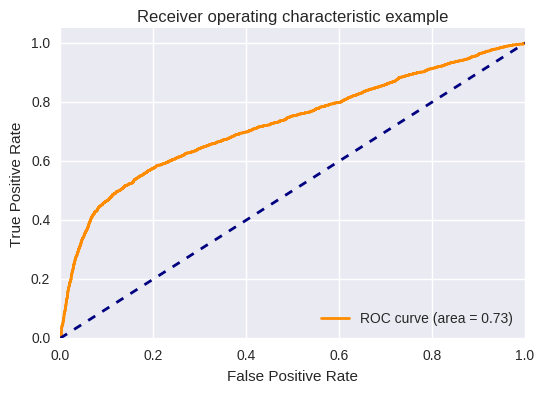

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
model = LogisticRegression(C=0.1)
y_pred = model.fit(X_train, y_train).predict_proba(X_test)
y_pred = np.array([x[1] for x in y_pred])
fpr, tpr, thresholds = roc_curve(y_test+1, y_pred, pos_label=2)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Gradient Boosting Trees

## Redução de dimensionalidade

<Container object of 3 artists>

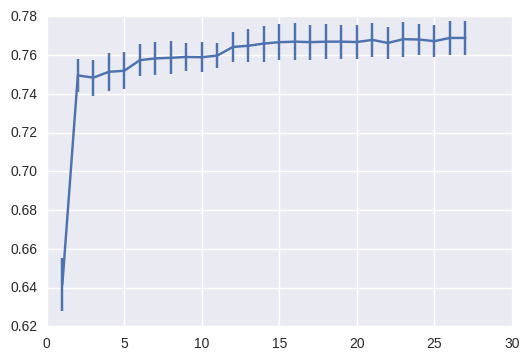

In [15]:
score_list = []
error_list = []
n_dims = range(1,train.shape[1])
model = GradientBoostingClassifier()
for dim in n_dims:
    reduced_data = PCA(n_components=dim).fit_transform(X)
    scores = cross_val_score(model, reduced_data, y,
                             cv=5, n_jobs=-1, scoring='roc_auc')
    score_list.append(np.mean(scores))
    error_list.append(np.std(scores))
plt.errorbar(n_dims, score_list, yerr=error_list)

## Taxa de Aprendizado

A variação da taxa de aprendizado mostrou um máximo em aproximadamente 0,1.

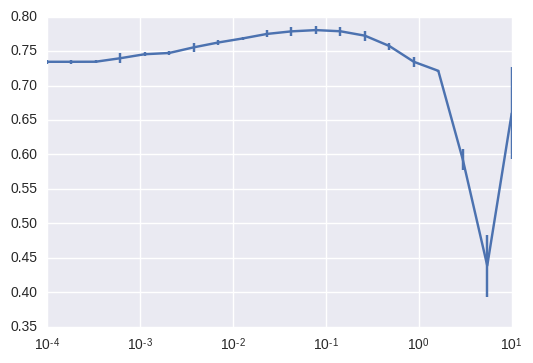

In [52]:
score_list = []
error_list = []
learning_rates = np.logspace(-4,1,20)
for learning_rate in learning_rates:
    model = GradientBoostingClassifier(learning_rate=learning_rate)
    scores = cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring='roc_auc')
    score_list.append(np.mean(scores))
    error_list.append(np.std(scores))
plt.errorbar(learning_rates, score_list, yerr=error_list)
plt.xscale('log')

## Subamostragem

Corresponde a porcentagem de amostras que são utilizadas para fitar os classificadores do ensemble. Valores menores que 1 tendem a reduzir a variância porém aumentar o bias do modelo. Não houve grande variação ao varia a taxa de subamostragem, portanto optou-se por mante-la igual a 1.

<Container object of 3 artists>

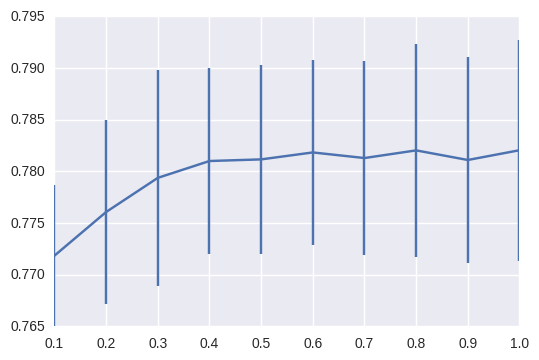

In [62]:
score_list = []
error_list = []
subsamples = np.linspace(0.1,1,10)
for subsample in subsamples:
    model = GradientBoostingClassifier(subsample=subsample)
    scores = cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring='roc_auc')
    score_list.append(np.mean(scores))
    error_list.append(np.std(scores))
plt.errorbar(subsamples, score_list, yerr=error_list)

## Numero de features a se considerar para um split

Utilizar um número de features menor que o total costuma reduzir a variância do modelo em troca de um aumento do bias. Ao variar essa taxa não observou-se um valor estatisticamente superior ao outro, devido as grandes barras de erro. Optou-se por utilizar a taxa que apresentou maior AUC médio, no caso, 0.2.

<Container object of 3 artists>

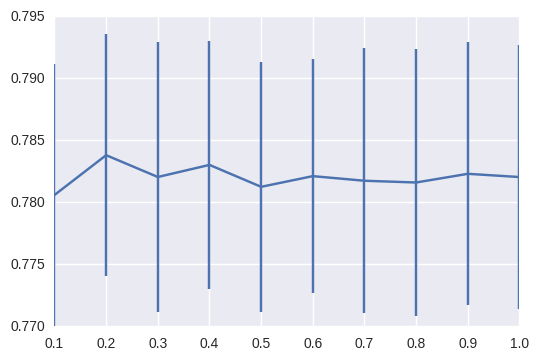

In [63]:
score_list = []
error_list = []
max_features_list = np.linspace(0.1,1,10)
for max_features in max_features_list:
    model = GradientBoostingClassifier(max_features=max_features)
    scores = cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring='roc_auc')
    score_list.append(np.mean(scores))
    error_list.append(np.std(scores))
plt.errorbar(max_features_list, score_list, yerr=error_list)

## Máxima Profundidade

Variou-se o número de camadas máximo que cada árvore pode ter. Não observou-se um valor estatisticamente superior ao outro, devido as grandes barras de erro. Optou-se por utilizar a taxa que apresentou maior AUC médio, no caso, 3.

<Container object of 3 artists>

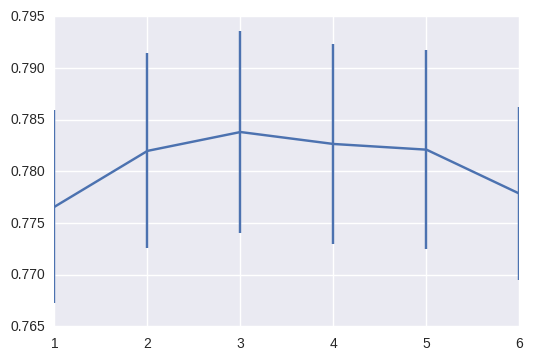

In [68]:
score_list = []
error_list = []
max_depths = [1,2,3,4,5,6]
for max_depth in max_depths:
    model = GradientBoostingClassifier(max_features=0.2, max_depth=max_depth)
    scores = cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring='roc_auc')
    score_list.append(np.mean(scores))
    error_list.append(np.std(scores))
plt.errorbar(max_depths, score_list, yerr=error_list)

# Mínimo de amostras para um split

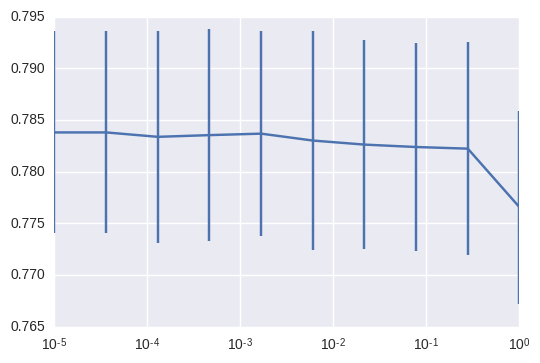

In [71]:
score_list = []
error_list = []
min_samples_splits = np.logspace(-5,0,10)
for min_samples_split in min_samples_splits:
    model = GradientBoostingClassifier(max_features=0.2, min_samples_split=min_samples_split)
    scores = cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring='roc_auc')
    score_list.append(np.mean(scores))
    error_list.append(np.std(scores))
plt.errorbar(min_samples_splits, score_list, yerr=error_list)
plt.xscale('log')

<Container object of 3 artists>

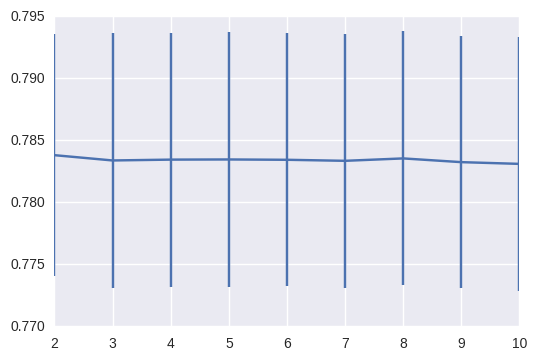

In [72]:
score_list = []
error_list = []
min_samples_splits = [2,3,4,5,6,7,8,9,10]
for min_samples_split in min_samples_splits:
    model = GradientBoostingClassifier(max_features=0.2, min_samples_split=min_samples_split)
    scores = cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring='roc_auc')
    score_list.append(np.mean(scores))
    error_list.append(np.std(scores))
plt.errorbar(min_samples_splits, score_list, yerr=error_list)